# Импорт модулей и библиотек

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import string
import re
import seaborn as sns
import gensim

from gensim.models import Word2Vec

import gensim.downloader as api
from tqdm import tqdm_notebook as tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, homogeneity_score
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isaev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\isaev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Чтение и препроцессинг данных

In [2]:
df = pd.read_csv('Data/total_news_without_dupl.csv', sep=';')

In [3]:
def preprocessing(data, lemmatizer = WordNetLemmatizer(), 
                  stop_words = stopwords.words('english')):
    texts = data.values.tolist()
    new_text = []

    for i in tqdm(range(len(texts))):
        text = texts[i]

        # приводим к нижнему регистру и дропаем стоп-слова
        punct_free = re.sub('[^a-zA-Z]', ' ', str(text).lower())
        punct_free = re.sub(r'\s.,_+', ' ', punct_free)
        stop_free = " ".join([i for i in punct_free.split() if i not in stop_words])
        lemma_text = ' '.join([lemmatizer.lemmatize(word) for word in stop_free.split(' ')])
        new_text.append(lemma_text)
    
    return new_text

In [4]:
nltk.download("stopwords")
text_title = preprocessing(df['title'])
text_summary = preprocessing(df['summary'])

text_title = [i.split() for i in text_title]
text_summary = [i.split() for i in text_summary]
df['title'] = text_title
df['summary'] = text_summary

all_text = text_title + text_summary

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isaev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\isaev\AppData\Local\Temp\ipykernel_28808\2382858649.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(texts))):


  0%|          | 0/6729 [00:00<?, ?it/s]

  0%|          | 0/6729 [00:00<?, ?it/s]

### Word2Vec

In [5]:
w2v_model = Word2Vec(sentences=all_text, vector_size=100, 
                    window=5, min_count=2)
pretrain_model = api.load('word2vec-google-news-300')

In [6]:
w2v_model.build_vocab(all_text)
words = w2v_model.wv.index_to_key
vocab_size = len(words)

print("Vocab size =", vocab_size)

Vocab size = 7377


In [7]:
pretrain_model.most_similar("apple")

[('apples', 0.720359742641449),
 ('pear', 0.6450697183609009),
 ('fruit', 0.6410146355628967),
 ('berry', 0.6302295327186584),
 ('pears', 0.613396167755127),
 ('strawberry', 0.6058260798454285),
 ('peach', 0.6025872826576233),
 ('potato', 0.5960935354232788),
 ('grape', 0.5935863852500916),
 ('blueberry', 0.5866668224334717)]

### Матрица эмбедингов

In [8]:
def embedding_matrix(text, model):
    
    """
       На вход: словарь tokenizer.word_index 
       модель word2vec
        
       На выходе: матрица эмбедингов текста
    """
    
    embedding_matrix = np.zeros((len(text), 300))
    for sentence in text:
        for word in sentence:
            if word in model:
                embedding_matrix[text.index(sentence)] = model[word]

    return embedding_matrix

In [9]:
# получим матрицы с эмбедингами для всех текстовых признаков
matrix_emb_title = embedding_matrix(text_title, pretrain_model)
matrix_emb_summary = embedding_matrix(text_summary, pretrain_model)

# и соединим их
matrix_emb = pd.concat([pd.DataFrame(matrix_emb_title),
                         pd.DataFrame(matrix_emb_summary)], axis=1)

# Clustering

In [10]:
model_names = ['DBSCAN', 'Afinity', 'AgglomerativeClustering']
metrics = {'Silhouette score':silhouette_score, 
           'Davies Bolduin index': davies_bouldin_score, 
           'Calinski Harabasz': calinski_harabasz_score}

compare = pd.DataFrame([])

In [11]:
def calculate_metrics(matrix, predict_labels, metrics={}):
    if len(metrics) == 0:
        raise ValueError('metrics are empty')
        
    results = dict()
    for key in metrics:
        results[key] = metrics[key](matrix, predict_labels)
    
    return results

### TSNE

In [12]:
X_embedded = TSNE(n_components=2, learning_rate=200, n_iter=1000, min_grad_norm=0.0000001, method='barnes_hut',
                  init='random', perplexity=10).fit_transform(matrix_emb)

# Вывод результатов
print('New Shape of X: ', X_embedded.shape)

New Shape of X:  (6729, 2)


### DBSCAN

In [13]:
label_dbsc = DBSCAN(eps=5, min_samples=10).fit_predict(matrix_emb)

In [21]:
np.unique(label_dbsc, axis=0)

array([-1,  0], dtype=int64)

In [14]:
# Визуализация
import plotly.express as px # для визуализации данных


# Создание диаграммы разброса
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 opacity=1, color=label_dbsc.astype(str))

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

In [19]:
res_dbscan = calculate_metrics(matrix_emb, label_dbsc, metrics=metrics)  
compare = compare.append(res_dbscan, ignore_index=True)

C:\Users\isaev\AppData\Local\Temp\ipykernel_12164\4042474270.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [20]:
compare

Silhouette score  Davies Bolduin index  Calinski Harabasz
0          0.189146              7.129921           5.355679

### Affinity

In [21]:
model_aff = AffinityPropagation(damping=0.65, max_iter=400) \
.fit(matrix_emb)

In [22]:
print(np.unique(model_aff.labels_))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [23]:
# Создание диаграммы разброса
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 opacity=1, color=model_aff.labels_.astype(str))

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

In [24]:
res_afinity = calculate_metrics(matrix_emb, model_aff.labels_, metrics=metrics)  
compare = compare.append(res_afinity, ignore_index=True)

C:\Users\isaev\AppData\Local\Temp\ipykernel_12164\206078529.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [25]:
compare

Silhouette score  Davies Bolduin index  Calinski Harabasz
0          0.189146              7.129921           5.355679
1          0.066317              2.125553           9.337819

### KMeans: метод локтя

In [26]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(matrix_emb)
    kmeanModel.fit(matrix_emb)
  
    distortions.append(sum(np.min(cdist(matrix_emb, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / matrix_emb.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(matrix_emb, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / matrix_emb.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [27]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 3.812409504269567
2 : 3.7766785810607395
3 : 3.7527838410086543
4 : 3.7308231615820455
5 : 3.7096813322658915
6 : 3.6928363194437948
7 : 3.6805338264312093
8 : 3.6685961254484463
9 : 3.6574351651721098
10 : 3.648038732694837
11 : 3.640175575388707
12 : 3.636940609155569
13 : 3.6317892911944436
14 : 3.621142076809158
15 : 3.62010247086022
16 : 3.609317716156017
17 : 3.5952661303904048
18 : 3.5977645366560442
19 : 3.596222145180746
20 : 3.5858875856059687
21 : 3.580955049588781
22 : 3.5800243943534746
23 : 3.573495049239657
24 : 3.567517553239115
25 : 3.5675859126495713
26 : 3.5615422519208
27 : 3.5552848192188673
28 : 3.5522403320150957
29 : 3.5409947264132606


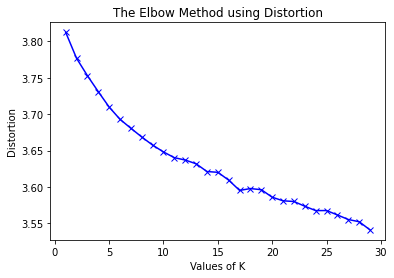

In [28]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [29]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 99859.74894179146
2 : 97954.23029808159
3 : 96754.76937311955
4 : 95613.09769229022
5 : 94692.43651229104
6 : 93850.49634017763
7 : 93235.27328002558
8 : 92660.9498173284
9 : 92112.11710222383
10 : 91756.49720438081
11 : 91282.97553313013
12 : 91142.86284990092
13 : 90858.72075582675
14 : 90313.79756348084
15 : 90334.62544649476
16 : 89894.22478810215
17 : 89308.70315361588
18 : 89279.24428509077
19 : 89309.96783053728
20 : 88771.81245246186
21 : 88608.88711257257
22 : 88445.41329850713
23 : 88179.7454029903
24 : 87932.27975056556
25 : 87868.63927675878
26 : 87706.57859347176
27 : 87432.24141934507
28 : 87208.46565784558
29 : 86777.31275931529


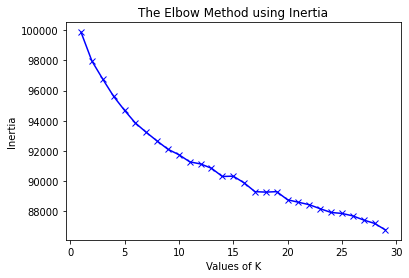

In [30]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Вывод по методу локтя:
Выделить какое-то определенное значение кластера с помощью этого метода не получилось, так как не очевидно, что какой-то из приведенных на графике значений выделяется как "локоть"

### Иерархическая кластеризация

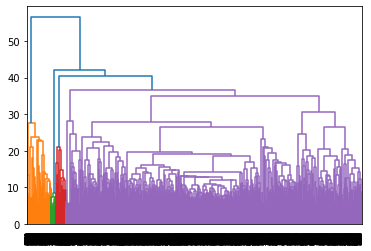

In [15]:
linkage_data = linkage(matrix_emb, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

In [16]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

In [18]:
labels = hierarchical_cluster.fit_predict(matrix_emb)

In [19]:
# Создание диаграммы разброса
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 opacity=1, color=labels.astype(str))

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

In [35]:
res_agglom = calculate_metrics(matrix_emb, labels, metrics=metrics)  
compare = compare.append(res_agglom, ignore_index=True)

C:\Users\isaev\AppData\Local\Temp\ipykernel_12164\753032866.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [36]:
compare.index = model_names
compare

Silhouette score  Davies Bolduin index  \
DBSCAN                           0.189146              7.129921   
Afinity                          0.066317              2.125553   
AgglomerativeClustering          0.057522              4.015005   

                         Calinski Harabasz  
DBSCAN                            5.355679  
Afinity                           9.337819  
AgglomerativeClustering         109.829831

### Results

In [37]:
result_matrix = matrix_emb
result_matrix["target_dbs"] = label_dbsc
result_matrix["target_agglom"] = labels

In [38]:
result_matrix

0         1         2         3         4         5         6  \
0    -0.044678 -0.021362 -0.015076  0.088379 -0.059814  0.349609 -0.043701   
1    -0.154297 -0.080078  0.113281  0.470703 -0.041504  0.045654 -0.203125   
2     0.143555  0.045654 -0.176758  0.273438 -0.144531 -0.044189  0.283203   
3     0.115234 -0.012512 -0.022949  0.194336  0.109375  0.042725  0.212891   
4     0.143555  0.045654 -0.176758  0.273438 -0.144531 -0.044189  0.283203   
...        ...       ...       ...       ...       ...       ...       ...   
6724  0.127930  0.119141 -0.086914  0.163086  0.090332  0.196289 -0.032471   
6725  0.103516 -0.287109 -0.012756 -0.113770 -0.062500  0.211914 -0.167969   
6726  0.062988  0.164062 -0.125000 -0.071289 -0.020874  0.035400 -0.058838   
6727 -0.294922  0.084473  0.010315  0.345703 -0.093750  0.055420  0.131836   
6728  0.153320  0.071777 -0.024170  0.131836 -0.067383 -0.107910  0.080078   

             7         8         9  ...       292       293       294  \
0     0.022217  0.283203  0.226562  ... -0.275391  0.167969 -0.204102   
1    -0.357422 -0.059082  0.031250  ...  0.191406 -0.081055  0.081055   
2    -0.100586  0.136719  0.126953  ... -0.062500  0.006805 -0.089844   
3     0.013794  0.132812  0.094727  ...  0.003571 -0.095703 -0.165039   
4    -0.100586  0.136719  0.126953  ...  0.000000  0.000000  0.000000   
...        ...       ...       ...  ...       ...       ...       ...   
6724 -0.028076  0.000732  0.200195  ...  0.060303 -0.018555 -0.166016   
6725 -0.184570  0.071289  0.186523  ... -0.112305  0.077148  0.095703   
6726 -0.039307  0.121582 -0.101074  ... -0.048584  0.039795 -0.289062   
6727 -0.273438 -0.118164  0.312500  ... -0.244141 -0.077148  0.047607   
6728 -0.113770  0.085938  0.079102  ... -0.156250  0.246094  0.244141   

           295       296       297       298       299  target_dbs  \
0     0.199219 -0.109375  0.065430 -0.060303 -0.128906           0   
1     0.163086  0.029907  0.024658  0.225586 -0.104004           0   
2     0.068848  0.059326  0.066406 -0.138672 -0.072754           0   
3    -0.091797  0.098145  0.221680  0.053223 -0.057129           0   
4     0.000000  0.000000  0.000000  0.000000  0.000000           0   
...        ...       ...       ...       ...       ...         ...   
6724 -0.180664 -0.043213  0.161133  0.098633  0.318359           0   
6725  0.093262  0.208984  0.183594  0.000206 -0.022095           0   
6726 -0.167969 -0.162109  0.026611  0.104492  0.203125           0   
6727 -0.075195 -0.149414 -0.044189  0.097168  0.067383           0   
6728 -0.101562  0.111816  0.114746  0.221680 -0.058350           0   

      target_agglom  
0                 0  
1                 1  
2                 0  
3                 0  
4                 0  
...             ...  
6724              0  
6725              0  
6726              0  
6727              1  
6728              0  

[6729 rows x 602 columns]

### Посмотрим на пересечения индексов двух моделей, которые две модели выделили в отдельный кластер

In [39]:
index_dbs = result_matrix[result_matrix["target_dbs"]==-1].index

In [40]:
len(index_dbs)

49

In [41]:
index_agglom = result_matrix[result_matrix["target_agglom"]==1].index

In [42]:
len(index_agglom)

486

In [43]:
intersection_list = list(set(index_agglom) & set(index_dbs))

In [44]:
intersection_list

[545, 291, 2924, 2886]

- Мы видим только 4 пересечения, посмотрим на содержимое этих пересечений

### Посмотрим на содержимое и смысл предложений с пересечениями

In [48]:
for i in intersection_list:
    print(f'{i}) ', df["title"].iloc[i])
    print(f'{i}) ', df["summary"].iloc[i])

545)  Daily Report: AOL to Take Over Display Advertising for Microsoft
545)  When the deal for Verizon to buy AOL was announced last month, executives from both companies said AOL was an appealing acquisition because of its advertising technology. On Monday, AOL showed some of that value in announcing a deal with Microsoft
291)  How to Verify if That Port Is Indeed a USB 3.0
291)  If you do not have the computer’s manual or specifications sheet, there are several ways to check, including looking for a blue light at the jack.
2924)  <div>Doing the Harlem Shake, Ajit Pai as You’ve Never Seen Him Before </div>
2924)  A video featuring the F.C.C. chief defending a repeal of net neutrality rules in a Santa suit and doing the Harlem Shake is attracting some disdain.
2886)  <div>Are Hotel Concierges Endangered by Apps? Don’t Bet on It</div>
2886)  The concierge may use digital tools, but as one veteran says, “There is no app that can get to know you quite like the human app.”


### Посмотрим на содержимое и смысл предложений отдельно по моделям

In [49]:
for i in index_dbs:
    print(f'{i} Title: ', df["title"].iloc[i])
    print(f'{i} Summary: ', df["summary"].iloc[i])

65 Title:  SpaceX Is a Throwback to the 1990s
65 Summary:  Google is investing in Elon Musk’s company, which is planning a broadband network of 4,000 satellites. The pioneering Teledesic tried something similar two decades ago but failed, notes Robert Cyran of Reuters Breakingviews.
128 Title:  Twitter Finance Chief’s Account Briefly Seized by Spammer
128 Summary:  The social network says that the account of its chief financial officer, Anthony Noto, was used to send a blast of spam on Tuesday. The company is investigating the incident.
291 Title:  How to Verify if That Port Is Indeed a USB 3.0
291 Summary:  If you do not have the computer’s manual or specifications sheet, there are several ways to check, including looking for a blue light at the jack.
545 Title:  Daily Report: AOL to Take Over Display Advertising for Microsoft
545 Summary:  When the deal for Verizon to buy AOL was announced last month, executives from both companies said AOL was an appealing acquisition because of its

### В итоге удалить:
- 128
- 291
- 564
- 789
- 1009
- 1711
- 1970
- 2585
- 2886
- 3560
- 4590

### Вывод:

Большая часть предложений, которые выделила модель DBSCAN, не имеют прямого отношения к Google, однако могут так или иначе финансовый рынок.

In [52]:
delete_list = [128, 291, 564, 789, 1009, 1711, 1970, 2585, 2886, 3560, 4590]
for i in delete_list:
    if df.index == i:
        print(12)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [53]:
to_array = []
for indx in df.index:
    if indx in delete_list:
        print(0)
        to_array.append(0)
    else:
        print(1)
        to_array.append(1)
        
df['relevance_flag'] = to_array

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [55]:
df.to_csv("results_dataframe.csv")

# ML

In [23]:
df = pd.read_csv('result.csv', index_col=0).drop("polarity_score", axis=1)

In [24]:
df.head(5)

date                                              title  \
0  2015-01-01      Digital Tax Increase to Take Effect in Europe   
1  2015-01-01      Web Freedom Is Seen as a Growing Global Issue   
2  2015-01-02                               A Day With Apple Pay   
3  2015-01-02  Daily Report: Web Freedom Is Seen as a Growing...   
4  2015-01-05            DealBook’s Most Popular Stories of 2014   

                                             summary  topic  \
0  New rules are coming into force for services l...      2   
1  The new year promises further attempts at onli...      1   
2  The success of Apple Pay will in part be deter...      0   
3  The new year promises further attempts at onli...      1   
4  Investors fleeing emerging markets, Facebook’s...      2   

                                   entities  subjectivity_score polarity  \
0                                  ['DATE']            0.477273      pos   
1                                  ['DATE']            0.477273      pos   
2                           ['ORG', 'DATE']            0.350000      neg   
3                                  ['DATE']            0.477273      pos   
4  ['ORG', 'ORG', 'ORG', 'PRODUCT', 'DATE']            0.700000      pos   

   target_shifted  
0               0  
1               0  
2               0  
3               0  
4               0

In [22]:
df.shape

(3535, 9)

In [28]:
model_classes = [LogisticRegression()]

model_names = ['LogisticRegression']

metrics = {'F1_Score':f1_score, 'Accuracy': accuracy_score, 'Precision': precision_score, 'Recall': recall_score}


parameters_tfidf = [{"TF_IDF__min_df": [0.00001, 0.0001, 0.001, 0.01], "TF_IDF__max_df": [0.0001, 0.001, 0.05, 0.1]}]
parameters_logregr = [{'GS_CV_logregr__C': [0.0001, 0.001, 0.01, 0.1, 1], 'GS_CV_logregr__random_state': [50]}]
# parameters_tree = [{'GS_CV_tree':[DecisionTreeClassifier()], 'GS_CV_tree__criterion':["entropy"],
#                     'GS_CV_tree__random_state': [50]}]
# parameters_rf = [{'GS_CV_RF':[RandomForestClassifier()], 'GS_CV_RF__n_estimators': [200, 500],
#                   'GS_CV_RF__max_depth': [6, 9], 'GS_CV_RF__random_state': [50]}]
# parameters_xgb = [{'GS_CV_xgb':[XGBClassifier()], 'GS_CV_xgb__learning_rate': [0.9],
#                    'GS_CV_xgb__n_estimators': [200, 500], 'GS_CV_xgb__max_depth': [6, 9], 'GS_CV_xgb__random_state':[50],
#                    'GS_CV_xgb__eval_metric':["mlogloss"], 'GS_CV_xgb__use_label_encoder': ["False"]}]

compare = pd.DataFrame([])

In [43]:
X = df.drop(["target_shifted", "topic", "entities", "subjectivity_score", "polarity", "date", "title"], axis=1)
y = df["target_shifted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [44]:
print(X_train.shape)
print(y_train.shape)

(2368, 1)
(2368,)


In [45]:
X_train

summary
2378  It’s important to preserve snapshots of China’...
1455  The first iPhone was released 10 years ago and...
1738  In this week’s tech newsletter, we discuss Spo...
2862  President Trump signed executive orders agains...
2354  The popularity of proposals for a government-r...
...                                                 ...
1130  Travis Kalanick plans to step down from the pr...
1294  Oil leaders will meet in Vienna to discuss way...
860   As Yahoo puts itself on the auction block, som...
3507  Several signs of economic stress may keep the ...
3174  The U.S. government has long tried to prevent ...

[2368 rows x 1 columns]

In [46]:
def calculate_metrics(y_test, y_pred, metrics={}):
    if len(metrics) == 0:
        raise ValueError('metrics are empty')
        
    results = dict()
    for key in metrics:
        results[key] = metrics[key](y_test, y_pred)
    
    return results

### Настраиваем гиперпараметры для каждой модели и вычисляем метрики.

#### 1. LogisticRegression

In [47]:
pipeline = Pipeline([('TF_IDF', TfidfVectorizer()),
                     ('GS_CV_logregr', LogisticRegression())])
    
grid_search = GridSearchCV(pipeline, param_grid=parameters_logregr)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
y_predict_logreg = best_clf.predict(X_test)
    
res_logregr = calculate_metrics(y_test, y_predict_logreg, metrics=metrics)  
compare = compare.append(res_logregr, ignore_index=True)

C:\Users\isaev\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\isaev\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\isaev\miniconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\isaev\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "C:\Users\i

ValueError: Found input variables with inconsistent numbers of samples: [1, 2368]

In [55]:
compare

F1_Score  Accuracy  Precision    Recall
0  0.000000  0.682432   0.000000  0.000000
1  0.000000  0.682432   0.000000  0.000000
2  0.000000  0.682432   0.000000  0.000000
3  0.000000  0.682432   0.000000  0.000000
4  0.000000  0.529279   0.000000  0.000000
5  0.227106  0.524775   0.484375  0.148325
6  0.465286  0.505631   0.473945  0.456938
7  0.469136  0.515766   0.484694  0.454545

In [27]:
best_clf

Pipeline(steps=[('TF-IDF', TfidfVectorizer(max_df=0.9, min_df=0.01)),
                ('GS_CV_logregr',
                 LogisticRegression(C=0.0001, random_state=50))])